In [4]:
import torch
import torch.nn as nn
import torch.functional as F
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

#### Create Auto Encoder to detect anomaly
#### Let's define AE structure

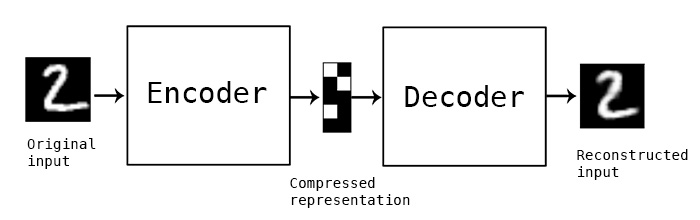

#### Since the encoder transforms our data into latent space with its own distributions, if we feed an anomalous object, which will have very different distribution parameters, our AE will reconstruct it poorly, so we will determine the anomalous object by the value of Loss

In [5]:
# Load data

master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [6]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [7]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


#### Our time series without anomalies for the training sample 

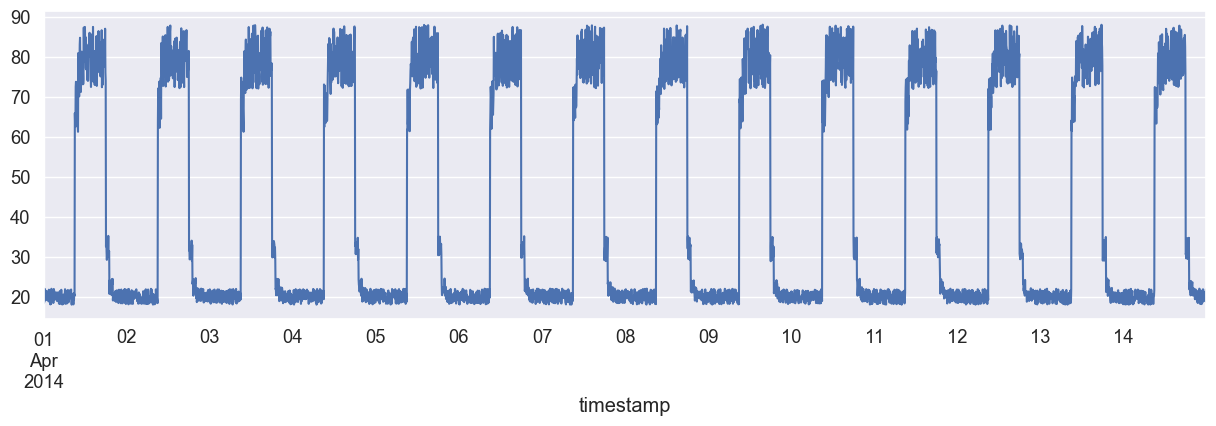

In [8]:
fig, ax = plt.subplots(figsize=(15, 4))
df_small_noise.plot(legend=False, ax=ax)
plt.show()

#### And our anomalies on the test

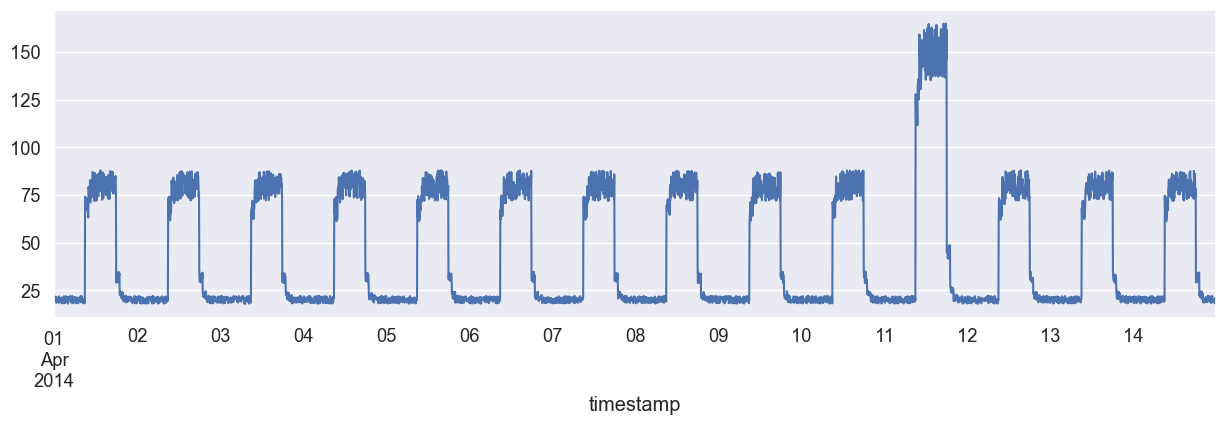

In [9]:
fig, ax = plt.subplots(figsize=(15, 4))
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

#### Now let's normalize our dataset

In [10]:
train_mean = df_small_noise.mean()
train_std = df_small_noise.std()
df_train_value = (df_small_noise - train_mean) / train_std

#### Let's generate sequences of 1 day duration **(288 time steps)**, and split the sample into train and val:

In [21]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return torch.FloatTensor(output).permute(0, 2, 1)


X = create_sequences(df_train_value.values)
x_train, x_val = train_test_split(X, test_size=0.9, shuffle=False)
print("Training input shape: ", x_train.shape)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=32)
val_loader = torch.utils.data.DataLoader(x_val, batch_size=32)

Training input shape:  torch.Size([374, 1, 288])


#### Now let's create AE model

In [22]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 16, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True)
        )
        self.Decoder = nn.Sequential(
            nn.ConvTranspose1d(16, 16, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(16, 32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(32, 1, kernel_size=7, stride=1, padding=3)
        )
    
    def encode(self, x):
        return self.Encoder(x)

    def forward(self, x):
        latent = self.Encoder(x)
        reconstructed = self.Decoder(latent)
        return reconstructed

In [23]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [24]:
model = AE().to(device)

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4, amsgrad=True)
loss_fn = torch.nn.MSELoss()

In [26]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

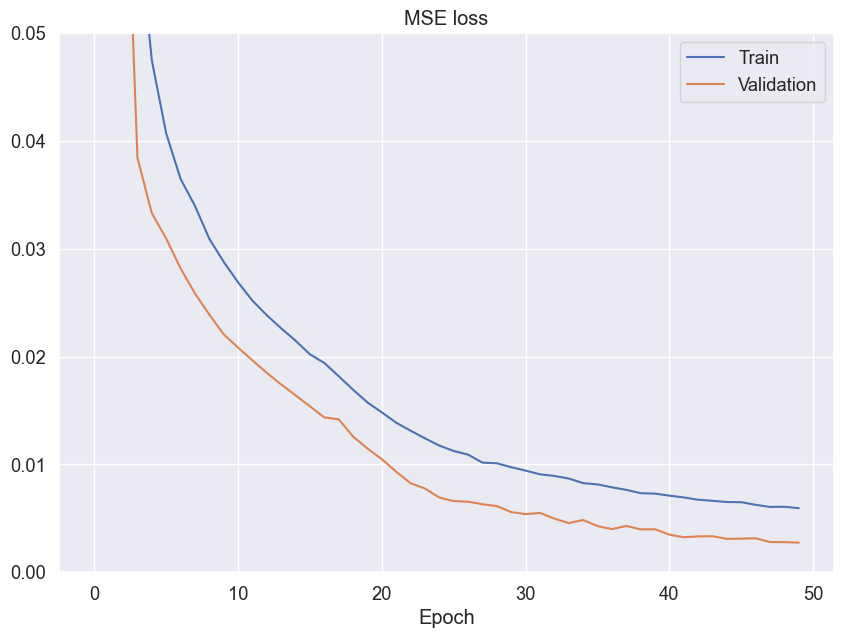

In [28]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

#### Now let's detect anomaly

Let's go through a few steps
1. determine the magnitude of MAE error on the training sample 
2. Remember the maximum MAE error value, this will be our threshold for the test sample, anything greater than this value will be considered an anomaly. We believe that there are no anomalies in the training sample
3. Let's go through the test sample, if the value of MAE error is greater than the threshold, then this object did not occur in the training and therefore will be an anomaly

In [29]:
X_loader = torch.utils.data.DataLoader(X, batch_size=1)
model.eval()
threshold = 0.0
x_pred = []

with torch.no_grad():
  for batch in X_loader:
    pred = model(batch.to(device)).cpu().numpy()
    x_pred.append(pred.ravel())
    mae_loss = np.mean(np.abs(pred - batch.numpy()))

    if mae_loss > threshold:
      threshold = mae_loss

print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.04441981


#### Check how our model predict data on the first day

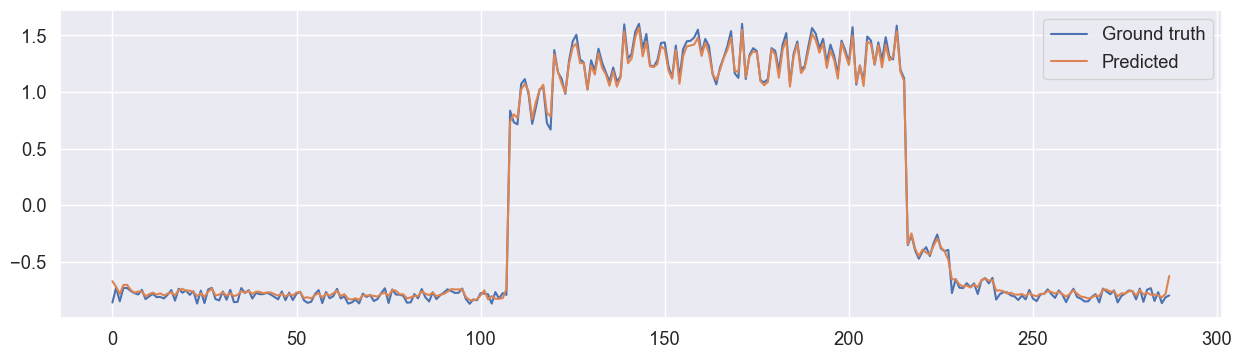

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(x_train[0].numpy().ravel(), label='Ground truth')
plt.plot(x_pred[0], label='Predicted')

plt.legend()
plt.show()

#### Detect anomaly on test data

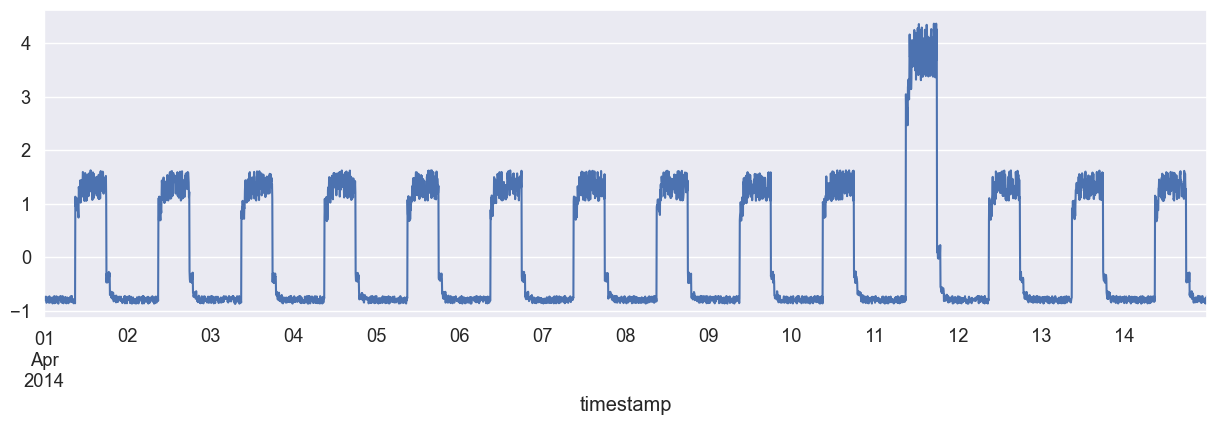

Test input shape:  torch.Size([3744, 1, 288])


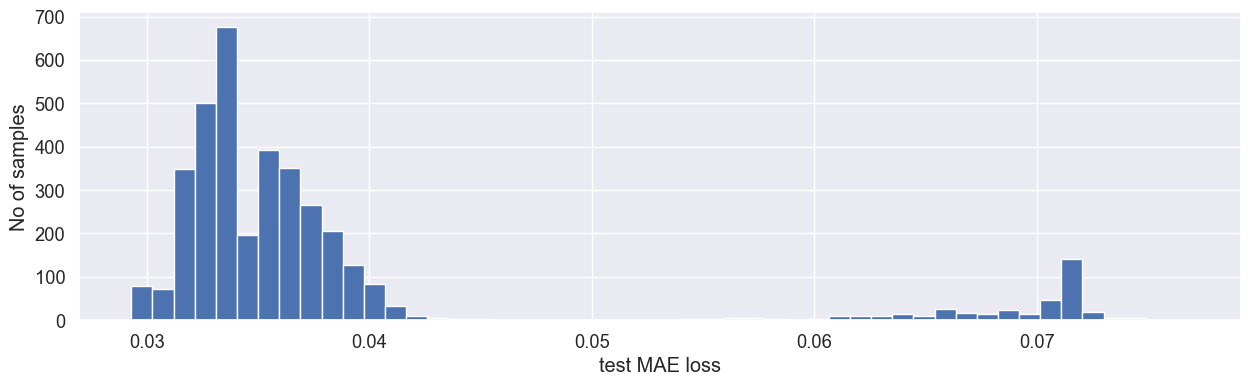

Number of anomaly samples:  398
Indices of anomaly samples:  (array([2519, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831,
       2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2

In [32]:
df_test_value = (df_daily_jumpsup - train_mean) / train_std
fig, ax = plt.subplots(figsize=(15, 4))
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
test_loader = torch.utils.data.DataLoader(x_test, shuffle=False)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.

test_losses = []
with torch.no_grad():
  for batch in test_loader:
    pred = model(batch.to(device)).cpu().numpy()
    mae_loss = np.mean(np.abs(pred - batch.numpy()))
    test_losses.append(mae_loss)

test_losses = np.array(test_losses).reshape((-1))

plt.figure(figsize=(15, 4))
plt.hist(test_losses, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_losses > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

#### As we can see the model has defined some anomaly indices, let's plot them on the graph

In [33]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

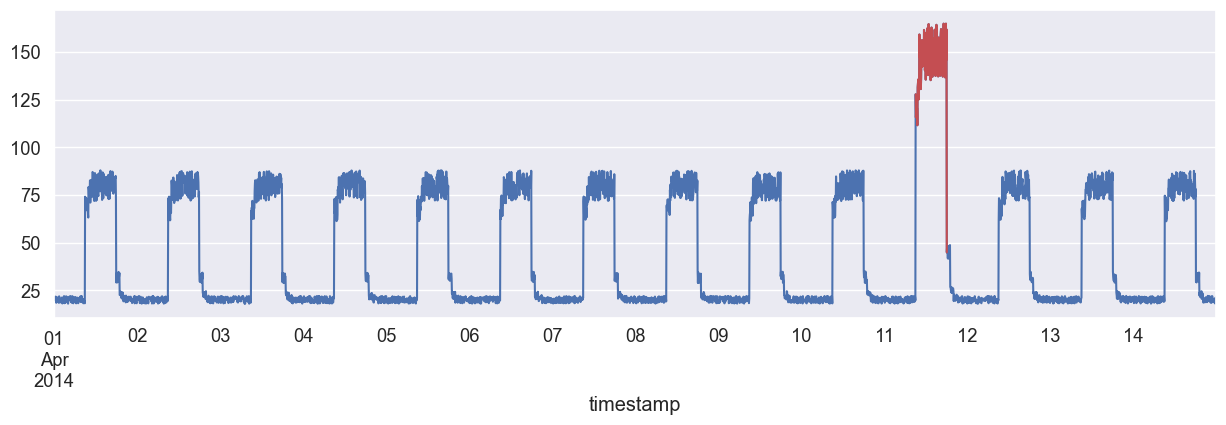

In [34]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(15, 4))
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()